# Application to real-world cases
We here want to demonstrate the necessary steps to real-world cases. A new manuspcript introducing the necessary steps, the results, as well as an uncertainty estimation based on the evaluation with glacier observations is published in Frontiers in Earth Science. 

## Set-up

In [2]:
import sys
import os
import salem

from initialization.core import *
from initialization.plots import *

from oggm import cfg, workflow,utils
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline
# settings for plots
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =15
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize']= 15 
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['figure.figsize'] = 10,10

In [3]:
cfg.initialize()

# path to working and plot directory
WORKING_DIR = 'workdir'
cfg.PATHS['working_dir'] = WORKING_DIR

utils.mkdir(cfg.PATHS['working_dir'], reset=False)
cfg.PATHS['plot_dir'] = os.path.join(cfg.PATHS['working_dir'], 'plots')
utils.mkdir(cfg.PATHS['plot_dir'], reset=False)

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True

# How many grid points around the glacier?
border = 160

# Set to True for operational runs
cfg.PARAMS['continue_on_error'] = True

# IMPORTANT!!! Otherwise the initialization method won't work as it rely on this output. 
cfg.PARAMS['store_model_geometry'] = True

# select Hintereisferner only
gdirs = workflow.init_glacier_directories('RGI60-11.00831',from_prepro_level=5, prepro_border=border)
gdir = gdirs[0]

2022-08-08 10:11:05: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-08-08 10:11:05: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-08-08 10:11:05: oggm.cfg: Multiprocessing: using all available processors (N=32)
2022-08-08 10:11:05: oggm.cfg: Multiprocessing switched ON after user settings.
2022-08-08 10:11:05: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2022-08-08 10:11:05: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2022-08-08 10:11:05: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2022-08-08 10:11:05: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2022-08-08 10:11:05: oggm.utils: /home/users/julia/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/centerlines/qc3/pcp2.5/no_match/RGI62/b_160/L5/RGI60-11/RGI60-11.00.tar verified successfully.


In [4]:
gdirs[0]

<oggm.GlacierDirectory>
  RGI id: RGI60-11.00831
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.071 km2
  Lon, Lat: (10.8228, 46.8394)
  Grid (nx, ny): (342, 349)
  Grid (dx, dy): (14.0, -14.0)

## The drawback of synthetic experiements
In the previous notebook we introduced the synthetic experiements, which do not necessarily represent real-world cases. In order to clarify this, we will create the synthetic experiment again:  


In [5]:
synthetic_experiments_parallel(gdirs, 1917,gdirs[0].rgi_date)

2022-08-08 10:11:08: oggm.core.flowline: (RGI60-11.00831) run_random_climate
2022-08-08 10:11:08: oggm.core.flowline: (RGI60-11.00831) flowline_model_run
2022-08-08 10:11:18: oggm.core.flowline: (RGI60-11.00831) run_from_climate_data_synthetic_experiment
2022-08-08 10:11:18: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-08-08 10:11:18: oggm.core.flowline: (RGI60-11.00831) flowline_model_run_synthetic_experiment


RGI state:   0.504 km, 0.07 km², 0.0 km³
synth. exp.: 1.204 km, 0.21 km², 0.01 km³


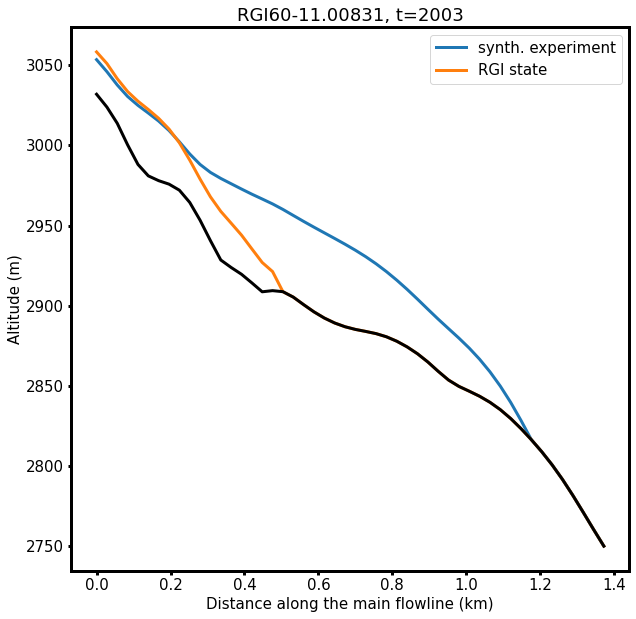

In [5]:

# reads the expermient model
ep = gdir.get_filepath('model_geometry', filesuffix='_synthetic_experiment')
ex_mod = FileModel(ep)

# read model_flowlines (RGI state)
fls = gdir.read_pickle('model_flowlines')
fls_mod = FluxBasedModel(flowlines=fls)
ex_mod.run_until(gdir.rgi_date)
x = (np.arange(ex_mod.fls[-1].nx) * ex_mod.fls[-1].dx * ex_mod.fls[-1].map_dx)[:50]/1000

# plot the surface elevations of the synthetic experiment and the RGI state
plt.plot(x,ex_mod.fls[-1].surface_h[:50], color='C0', label='synth. experiment')
plt.plot(x,fls_mod.fls[-1].surface_h[:50], color='C1', label='RGI state')
plt.plot(x,ex_mod.fls[-1].bed_h[:50], color='k')
plt.legend()
plt.title(gdir.rgi_id+', t='+str(gdir.rgi_date))
plt.xlabel('Distance along the main flowline (km)')
plt.ylabel('Altitude (m)');

print('RGI state:   '+ str(fls_mod.length_m/1000)+' km, '+str(round(fls_mod.area_km2,2)) +r' km², '+str(round(fls_mod.volume_km3,2)) +r' km³')
print('synth. exp.: '+ str(ex_mod.length_m/1000)+' km, '+str(round(ex_mod.area_km2,2)) +r' km², ' +str(round(ex_mod.volume_km3,2)) +r' km³')

The example above demonstrate well why the synthetic experiement did not always represent the reality. The synthetic experiment state differs obviously from the RGI state (the state obtained by the RGI outline and the underlying topography file). The synthetic experiement state is 0.7 km longer and thus also a reconstruction of this state would not represent realistic conditions. 

To this end, we developed the method further and introduce the so called calibration runs
## Real-world application: Calibration runs

With the help of the calibration runs we identify an optimal mass balance offset, such that the difference of the experiment to the area of the RGI state is as small as possible. To this end, a bisection method is used which stop thank to the quick convergence after 12 iterations latest. 

In [6]:
calibration_runs([gdir],1917)

2022-08-08 08:41:42: oggm.core.flowline: (RGI60-11.00831) run_random_climate_calibration_random_0.0
2022-08-08 08:41:42: oggm.core.flowline: (RGI60-11.00831) flowline_model_run_calibration_random_0.0
2022-08-08 08:41:46: oggm.core.flowline: (RGI60-11.00831) run_from_climate_data_calibration_past_0.0
2022-08-08 08:41:46: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-08-08 08:41:46: oggm.core.flowline: (RGI60-11.00831) flowline_model_run_calibration_past_0.0
2022-08-08 08:41:46: oggm.core.flowline: (RGI60-11.00831) run_random_climate_calibration_random_1000.0
2022-08-08 08:41:46: oggm.core.flowline: (RGI60-11.00831) flowline_model_run_calibration_random_1000.0
2022-08-08 08:41:47: oggm.core.flowline: (RGI60-11.00831) run_from_climate_data_calibration_past_1000.0
2022-08-08 08:41:47: oggm.core.flowline: You are attempting 

The function `calibration_runs` creates during each iteration a model_run outputfile with the filesuffix of the tested mass balance offset. Only the model with the smallest area difference to the RGI state is kept, all the others are deleted automatically in the end. 

In [7]:
# get calibration run output file (OGGM state)
ex = [f for f in os.listdir(gdir.dir) if f.startswith('model_geometry_calibration_past')][0]
dst = os.path.join(gdir.dir,ex)
cal_mod = FileModel(dst)
cal_mod.run_until(gdir.rgi_date)

# get the optimal mb offset value from file name 
optimal_mb_offset = float(dst.split('_')[-1].split('.nc')[0])
optimal_mb_offset

318.85

RGI state:       0.504 km, 0.07 km², 0.0 km³
calibration run: 0.756 km, 0.07 km², 0.0 km³
synth. exp.:     1.204 km, 0.21 km², 0.01 km³


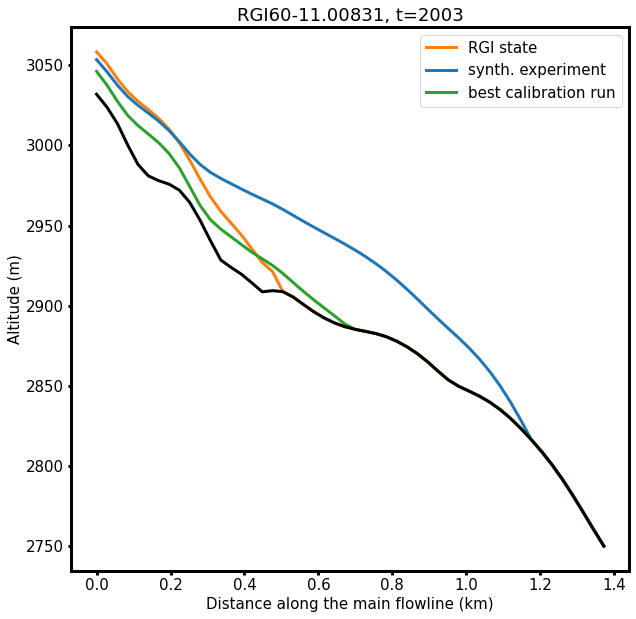

In [8]:
# reads the expermient model
ep = gdir.get_filepath('model_geometry', filesuffix='_synthetic_experiment')
ex_mod = FileModel(ep)
ex_mod.run_until(gdir.rgi_date)

# read model_flowlines (RGI state)
fls = gdir.read_pickle('model_flowlines')
fls_mod = FluxBasedModel(flowlines=fls)

x = (np.arange(fls_mod.fls[-1].nx) * fls_mod.fls[-1].dx * fls_mod.fls[-1].map_dx)[:50]/1000
plt.plot(x,fls_mod.fls[-1].surface_h[:50], color='C1', label='RGI state')
plt.plot(x,ex_mod.fls[-1].surface_h[:50], color='C0', label='synth. experiment')
plt.plot(x,cal_mod.fls[-1].surface_h[:50], color='C2', label='best calibration run')

plt.plot(x,cal_mod.fls[-1].bed_h[:50], color='k')
plt.legend()
plt.title(gdir.rgi_id+', t='+ str(gdir.rgi_date))
plt.xlabel('Distance along the main flowline (km)')
plt.ylabel('Altitude (m)');

print('RGI state:       '+ str(fls_mod.length_m/1000)+' km, '+str(round(fls_mod.area_km2,2)) +r' km², '+str(round(fls_mod.volume_km3,2)) +r' km³')
print('calibration run: '+ str(cal_mod.length_m/1000)+' km, '+str(round(cal_mod.area_km2,2)) +r' km², ' +str(round(cal_mod.volume_km3,2)) +r' km³')
print('synth. exp.:     '+ str(ex_mod.length_m/1000)+' km, '+str(round(ex_mod.area_km2,2)) +r' km², ' +str(round(ex_mod.volume_km3,2)) +r' km³')

## Real World Application: The actual initialization
Now, we are ready to start the actual initialization procedure. To this end you need to run the following function (This can take a long time!!!). Important for the real world application is that you hand over the optimal mass balance offset value `optimal_mb_offset` from above and the File Model from the calibration run `cal_mod`. Otherwise the function will use the default value (mb offset=0 and the synthetic experiment). We reduced the number of glacier candidates in this example to `n=20` (default value is `n=200`) in order to save computational costs. 

In [9]:
results = find_possible_glaciers(gdir, 1917, gdir.rgi_date, 20, ex_mod=cal_mod, mb_offset=optimal_mb_offset)

2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_81_-2.55
2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_196_-2.3
2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_1_-2.95
2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_9_-2.85
2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_16_-2.8
2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_121_-2.45
2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_36_-2.7
2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_0_-3.0
2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_100_-2.5
2022-08-08 08:42:14: oggm.core.flowline: (RGI60-11.00831) run_random_climate1917_random_289_-2.15
2022-08-08 08:42:14: oggm.core.flo

        time     volume_m3                  suffix
0      152.0  2.664805e+07  1917_random_1225_-1.25
1      153.0  2.695180e+07  1917_random_1225_-1.25
2      154.0  2.615250e+07  1917_random_1225_-1.25
3      155.0  2.745609e+07  1917_random_1225_-1.25
4      156.0  2.767592e+07  1917_random_1225_-1.25
...      ...           ...                     ...
29180  596.0  0.000000e+00   1917_random_9801_1.95
29181  597.0  0.000000e+00   1917_random_9801_1.95
29182  598.0  6.254747e+02   1917_random_9801_1.95
29183  599.0  0.000000e+00   1917_random_9801_1.95
29184  600.0  0.000000e+00   1917_random_9801_1.95

[29185 rows x 3 columns]


2022-08-08 08:43:12: oggm.core.flowline: (RGI60-11.00831) run_from_climate_data1917_past_1225_-1.25_508
2022-08-08 08:43:12: oggm.core.flowline: (RGI60-11.00831) run_from_climate_data1917_past_1225_-1.25_497
2022-08-08 08:43:12: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-08-08 08:43:12: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for example.
2022-08-08 08:43:12: oggm.core.flowline: (RGI60-11.00831) run_from_climate_data1917_past_1225_-1.25_503
2022-08-08 08:43:12: oggm.core.flowline: You are attempting to run_with_climate_data at dates prior to the RGI inventory date. This may indicate some problem in your workflow. Consider using `fixed_geometry_spinup_yr` for exam

In order to plot the results (here with 20 glacier candidates only) use: 

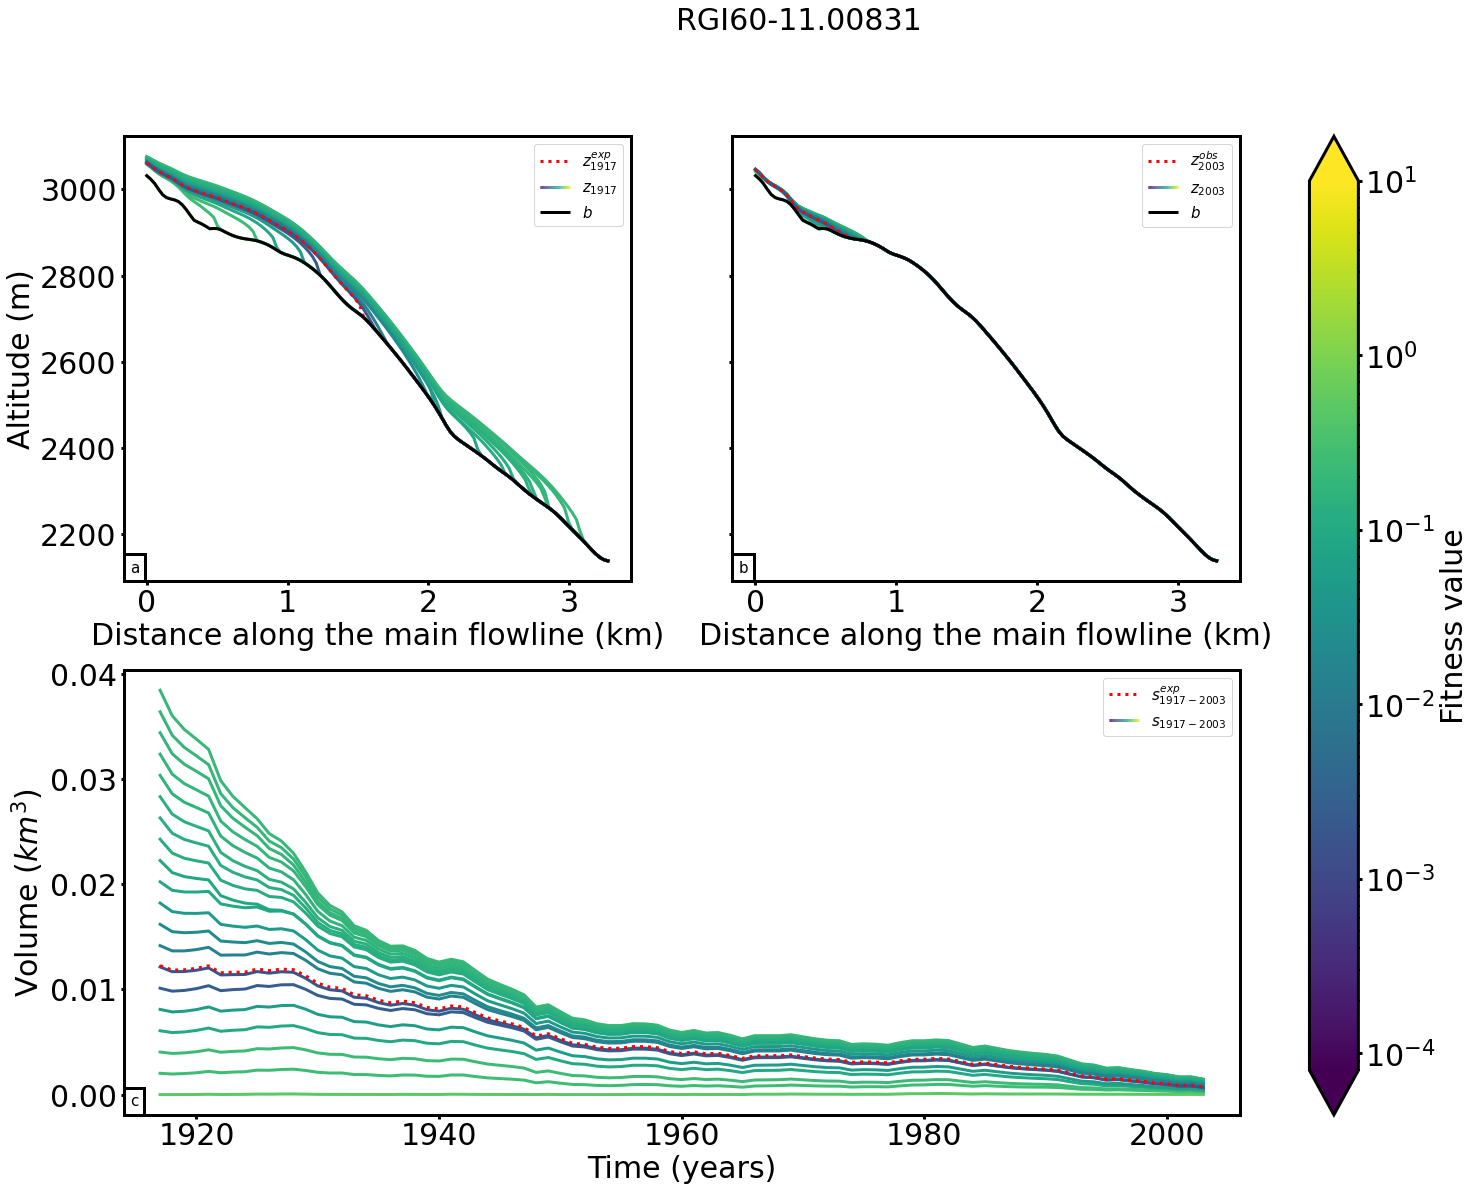

In [10]:
plot_fitness_values(gdir, results,cal_mod, 1917,gdir.rgi_date, cfg.PATHS['plot_dir'])

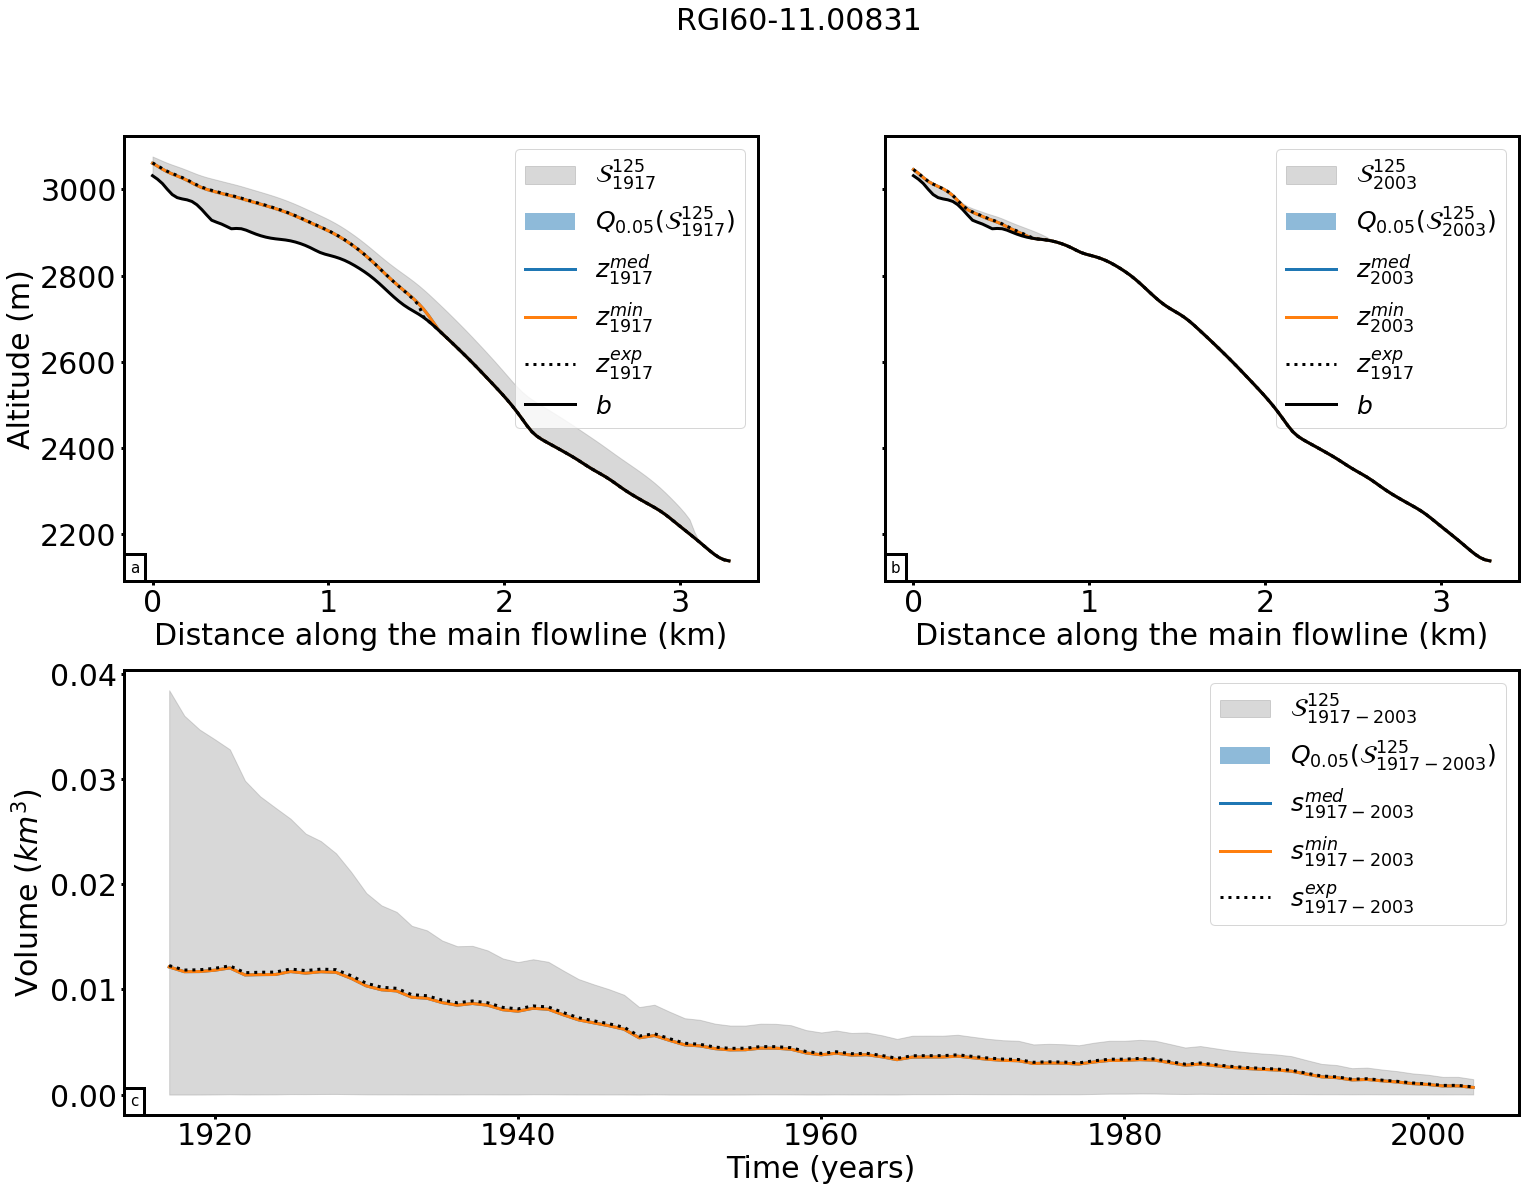

In [11]:
plot_median(gdir, results,125, cal_mod, 1917,gdir.rgi_date, cfg.PATHS['plot_dir'])